# LGD - Loss Given Default
This notebook will train a model to predict Loss Given Default (LGD). Let's start with feature selection

**LGD** indicates the proportion of the total exposure that remains unrecovered after a borrower has defaulted.

Hence, it is a better practice to build the model with data that borrowers have a `charged off` status (status of loss)

From the data provided, we know that:

* `funded_amnt`: reflects the total amount that was lost at the moment the borrower defaulted;

* `recoveries`: amount that has been recovered.

Hence, LGD can be defined as:

$LGD = \frac{funded\_amnt - recoveries}{funded\_amnt} = 1 - recovery\_rate$

In [1]:
import os
import sys

# Data Science
import numpy as np
import pandas as pd

# Data Visualization
import seaborn as sns
import plotly.io as pio # plotly is only used if you have a powerfull machine
import matplotlib.pyplot as plt
import plotly.figure_factory as ff

# pre-processing
from sklearn.preprocessing import StandardScaler

# machine learning
from sklearn.svm import SVC
from sklego.meta import ZeroInflatedRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor, XGBClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error

# save model
from joblib import dump

# hyper-parameter tuning
import optuna

# ignore all warnings
import warnings
warnings.filterwarnings('ignore')


In [2]:
train_df = pd.read_csv('../data/train/train.csv')

Only get records that have `charged off` status

In [3]:
DEFAULT_CATEGORIES = [
    "Charged Off",
    "Does not meet the credit policy. Status:Charged Off"
]

train_df = train_df[train_df["loan_status"].isin(DEFAULT_CATEGORIES)]
train_df.shape

(67068, 24)

In [4]:
TARGET_VARIABLE = "LGD"

train_df[TARGET_VARIABLE] = (train_df["recoveries"] / train_df["funded_amnt"])
train_df[TARGET_VARIABLE].describe()

count    67068.000000
mean         0.077419
std          0.097508
min          0.000000
25%          0.000000
50%          0.062718
75%          0.103930
max          1.294209
Name: LGD, dtype: float64

we will remove all the LGD that smaller than 0 because there is no loss on those borrower

In [5]:
train_df = train_df[train_df[TARGET_VARIABLE] <= 1]
train_df.shape

(67043, 25)

Let's check the distribution of the LGD

In [6]:
# fig = ff.create_distplot([train_df[TARGET_VARIABLE]], [TARGET_VARIABLE], bin_size=0.1)
# fig.show()

we can easily notice that our target variable is unevenly distributed, with a lot of values concentrated around 1 because default events in this data more likely happen.

## Feature Analysis
We are going to use features from PD model for alignment. However, we should analyze each features before coming up an appropriate regression model. Let's start by transforming features

### Feature Transformation

In [7]:
SELECTED_FEATURES = [
    "id", "purpose", "initial_list_status", "emp_length",
    "pub_rec", "grade", "addr_state", "term",
    "int_rate", "LGD"
]
train_df = train_df[SELECTED_FEATURES]

encoded_df = pd.get_dummies(train_df['grade'], prefix='grade')
train_df = train_df.drop('grade', axis=1)
train_df = pd.concat([train_df, encoded_df], axis=1)

ADDR_STATE_MAP = {
    "ID": ["ID"],
    "NE_ME": ["NE","ME"],
    "ND": ["ND"],
    "MS_AR_OK": ["MS", "OK", "AR"],
    "SD_LA_AL_AK_IN": ["SD", "LA", "AL", "AK", "IN"],
    "WV_MO_MD_OH": ["WV", "MO", "MD", "OH"],
    "NY_TN_KY_NJ_SC_NC_CT": ["NY", "TN", "KY", "NJ", "SC", "NC", "CT"],
    "IL": ["IL"],
    "PA_NM": ["PA", "NM"],
    "TX_VT": ["TX", "VT"],
    "FL_NV_GA": ["FL", "NV", "GA"],
    "VA_MN": ["MN", "VA"],
    "KS_DE_MA_MI_MT": ["KS", "DE", "MA", "MI", "MT"],
    "AZ_HI_WY_WI": ["AZ", "HI", "WY", "WI"],
    "RI_CA_NH": ["RI", "CA", "NH"],
    "WA_CO_OR_UT": ["WA", "CO", "OR", "UT"],
    "DC": ["DC"]
}

reverse_map = {state: group for group, states in ADDR_STATE_MAP.items() for state in states}

train_df["addr_state"] = train_df["addr_state"].map(reverse_map)

encoded_df = pd.get_dummies(train_df["addr_state"], prefix="addr_state")
train_df = train_df.drop("addr_state", axis=1)
train_df = pd.concat([train_df, encoded_df], axis=1)

PURPOSES_MAP = {
    "cred_card": ["credit_card"],
    "vacation": ["vacation"],
    "car": ["car"],
    "home_improv_debt_consol": ["home_improvement", "debt_consolidation"],
    "moving": ["moving"],
    "renewable_energy": ["renewable_energy"],
    "major_purchase_medical": ["major_purchase", "medical"],
    "other": ["other"],
    "wedding": ["wedding"],
    "small_business": ["small_business"],
    "house": ["house"]
}

reverse_map = {purpose: group for group, purposes in PURPOSES_MAP.items() for purpose in purposes}
train_df["purpose"] = train_df["purpose"].map(reverse_map)

encoded_df = pd.get_dummies(train_df["purpose"], prefix="purpose")
train_df = train_df.drop("purpose", axis=1)
train_df = pd.concat([train_df, encoded_df], axis=1)

encoded_df = pd.get_dummies(train_df["initial_list_status"], prefix="initial_list_status")
train_df = train_df.drop("initial_list_status", axis=1)
train_df = pd.concat([train_df, encoded_df], axis=1)


EMP_LENGTH_MAP = {
    "0": 0,
    "< 1 year": 1,
    "1 year": 1,
    "2 years": 2,
    "3 years": 3,
    '4 years': 4,
    '5 years': 5,
    '6 years': 6,
    '7 years': 7,
    '8 years': 8,
    '9 years': 9,
    '10+ years': 10
}
train_df["emp_length"] = train_df["emp_length"].map(EMP_LENGTH_MAP)

TERM_MAP = {
    " 36 months": 36.0,
    " 60 months": 60.0,
}
train_df["term"] = train_df["term"].map(TERM_MAP)

### Categorical Features
Since we use one-hot encoding for the categorical features, we should check the distribution of each dummy feature.

In [8]:
DUMMIES_PREFIX = ["grade", "addr_state", "purpose"]

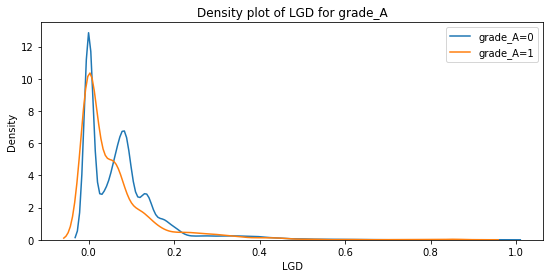

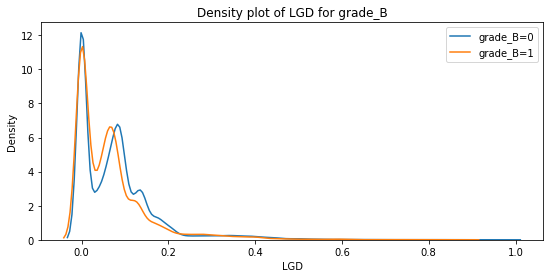

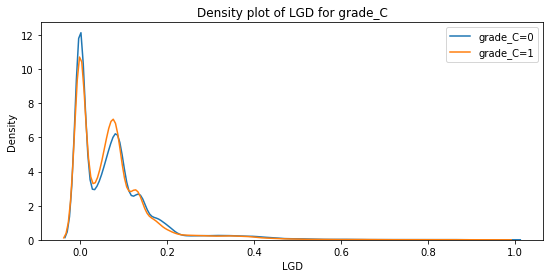

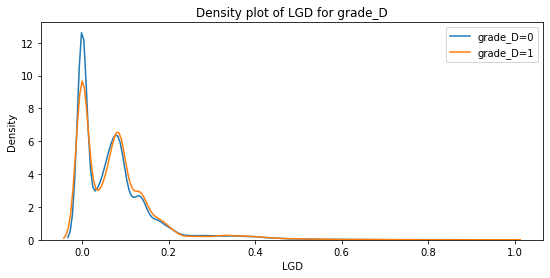

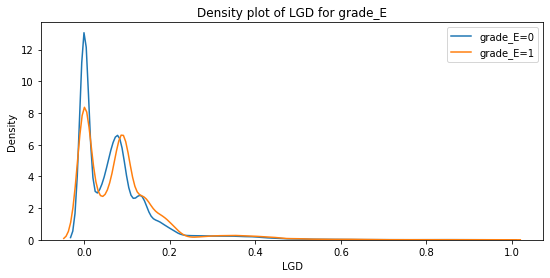

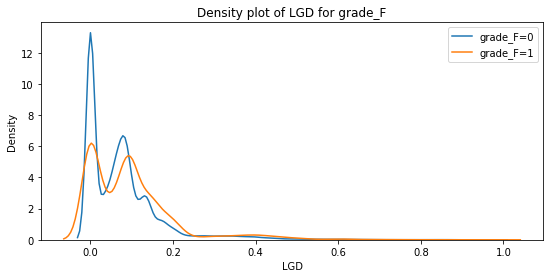

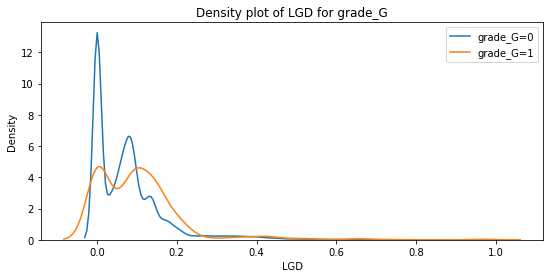

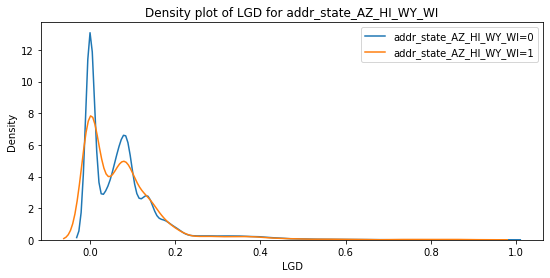

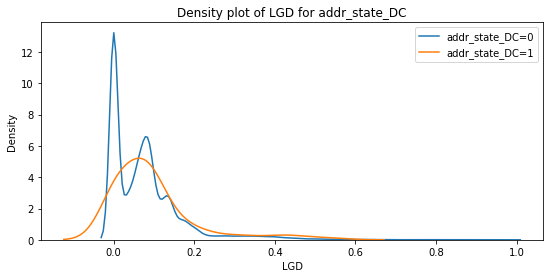

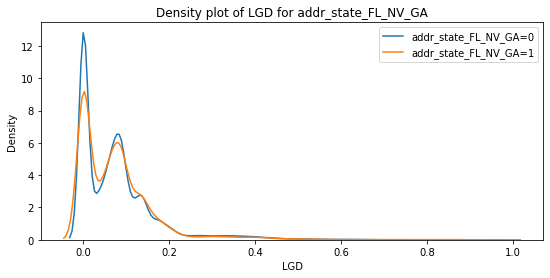

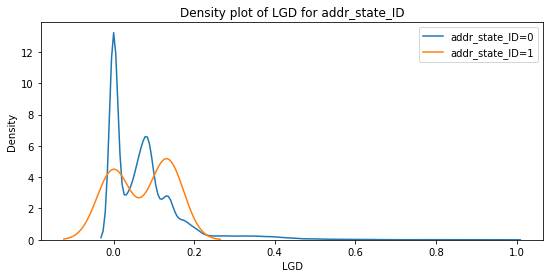

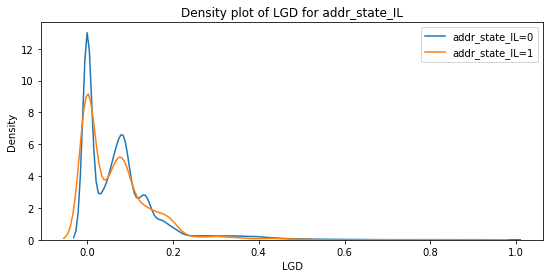

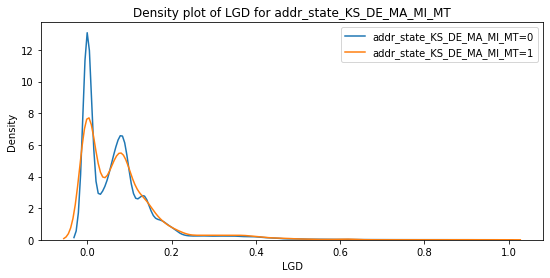

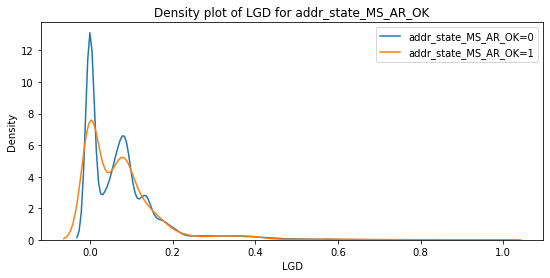

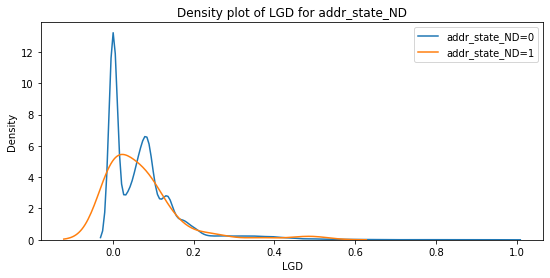

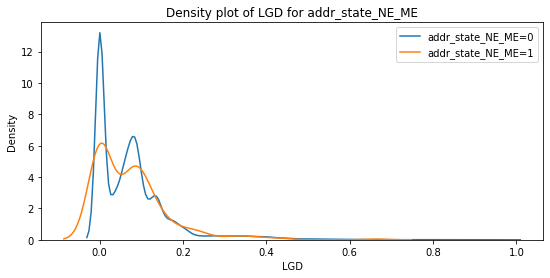

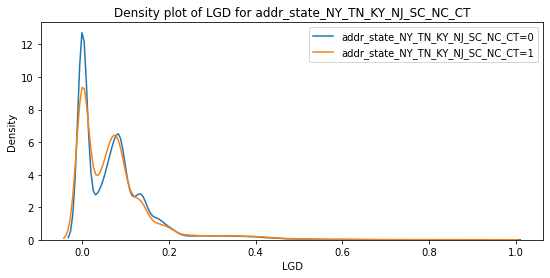

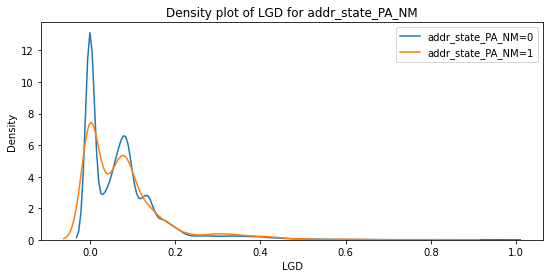

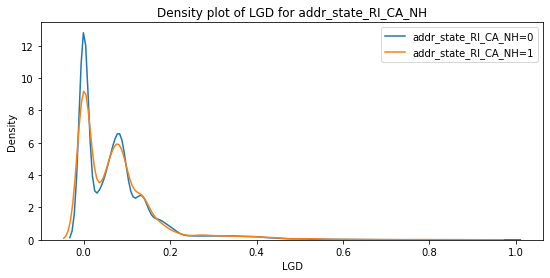

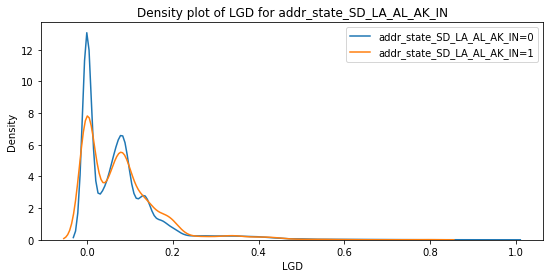

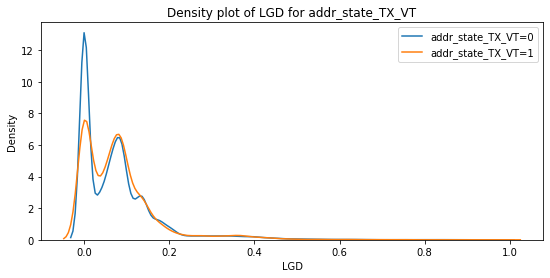

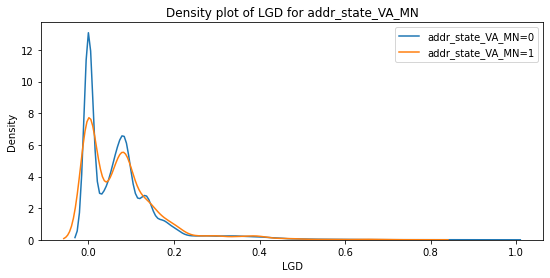

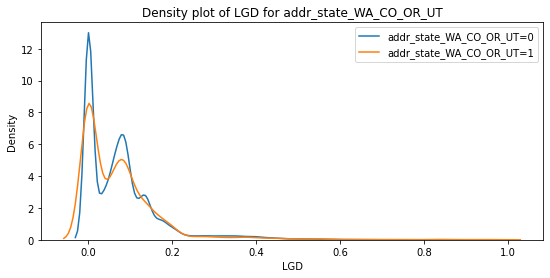

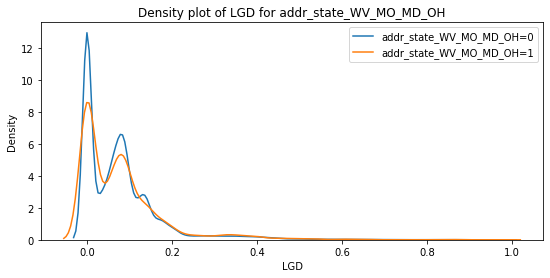

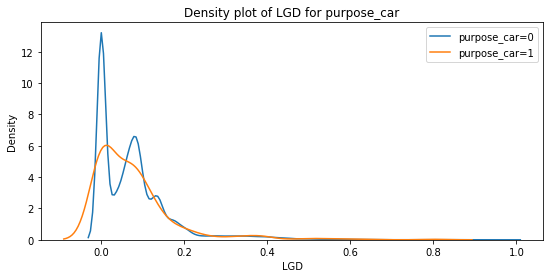

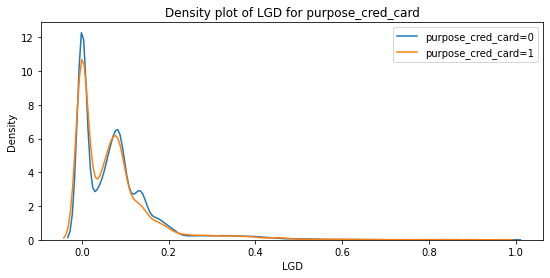

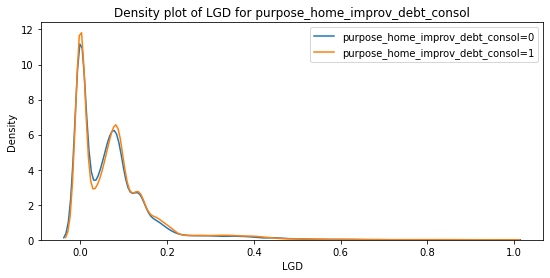

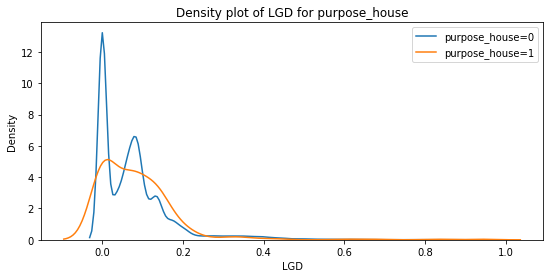

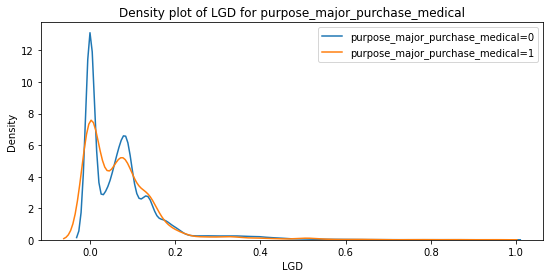

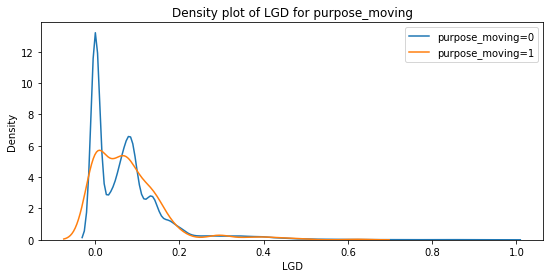

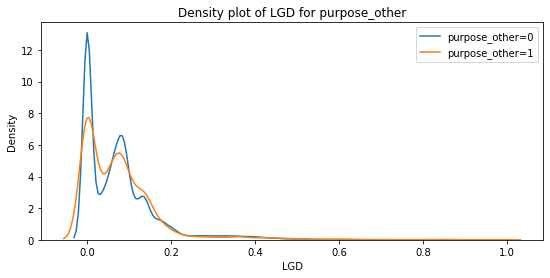

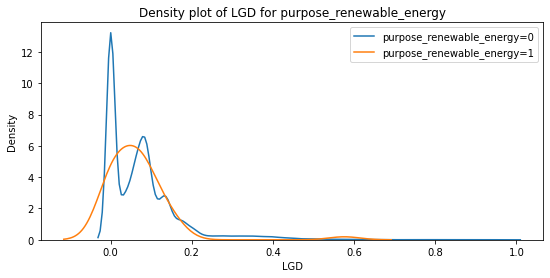

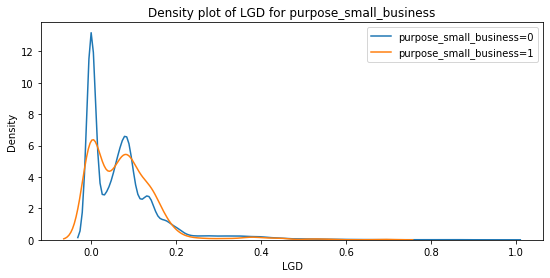

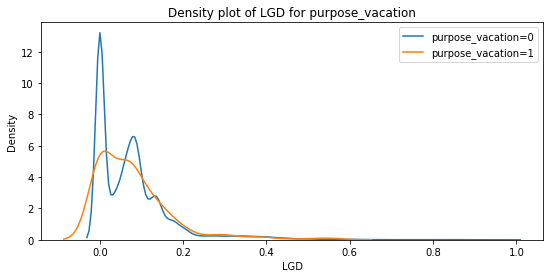

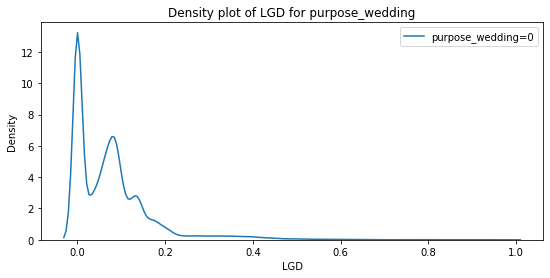

In [9]:
for prefix in DUMMIES_PREFIX:
    dummy_cols = [col for col in train_df.columns if col.startswith(prefix)]
    
    for col in dummy_cols:

        group0 = train_df[train_df[col] == 0][TARGET_VARIABLE]
        group1 = train_df[train_df[col] == 1][TARGET_VARIABLE]

        plt.figure(figsize=(9, 4)) 
        sns.kdeplot(group0, label=f'{col}=0')
        sns.kdeplot(group1, label=f'{col}=1')
        plt.legend()
        plt.title(f'Density plot of {TARGET_VARIABLE} for {col}')
        plt.show()

Most of the distribution diagrams show that the target feature highly inflates to zeros, whichs can cause the regression performance reduces. Hence, we can apply either zero-inflated regression, or tweedie-dist regression.

We can see that there is not value for purpose_wedding. It can be explained because the value "wedding" in "purpose" features have no charged off value. I one-hot encoded the feature by the map from PD model. Hence we need to remove the 'purpose wedding features'

In [10]:
train_df = train_df.drop('purpose_wedding', axis=1)

### Numerical Features

<AxesSubplot:>

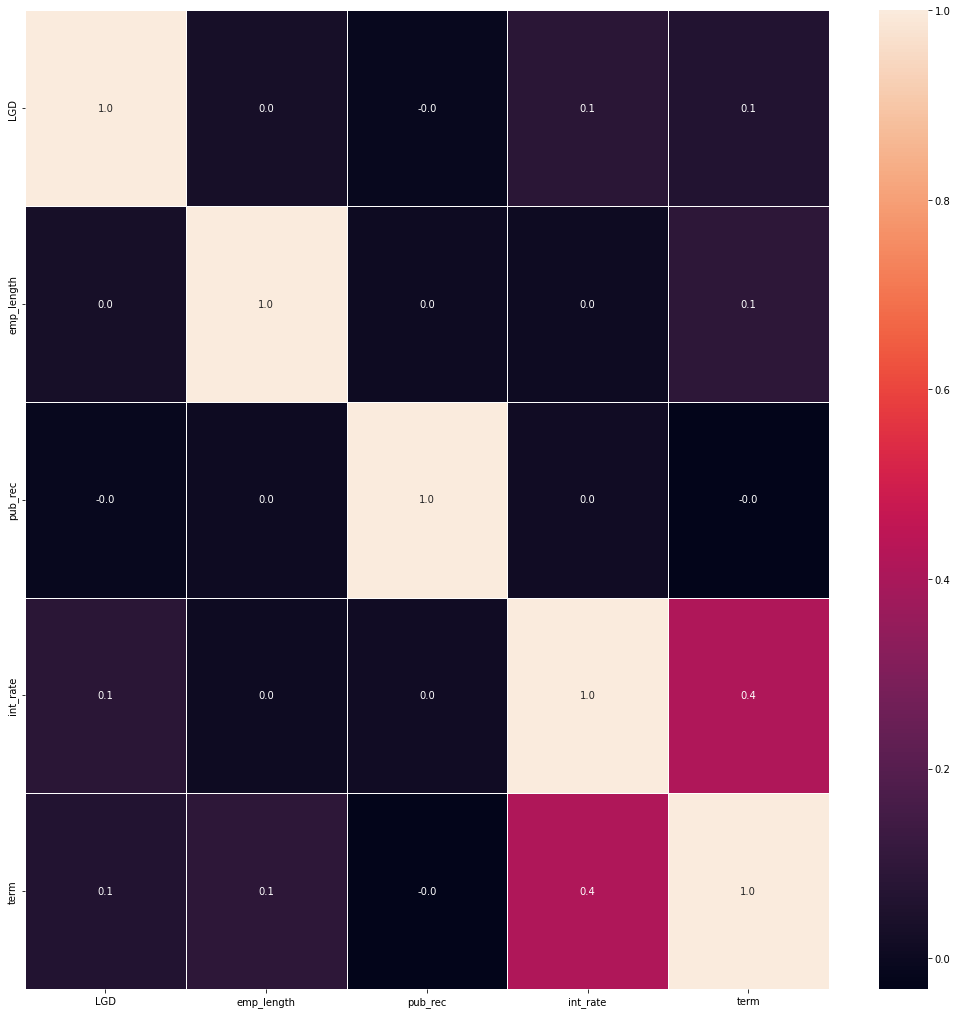

In [11]:
NUMERICAL_FEATURES = ['LGD', 'emp_length', 'pub_rec', 'int_rate', 'term']
fig,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(train_df[NUMERICAL_FEATURES].corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)


<AxesSubplot:>

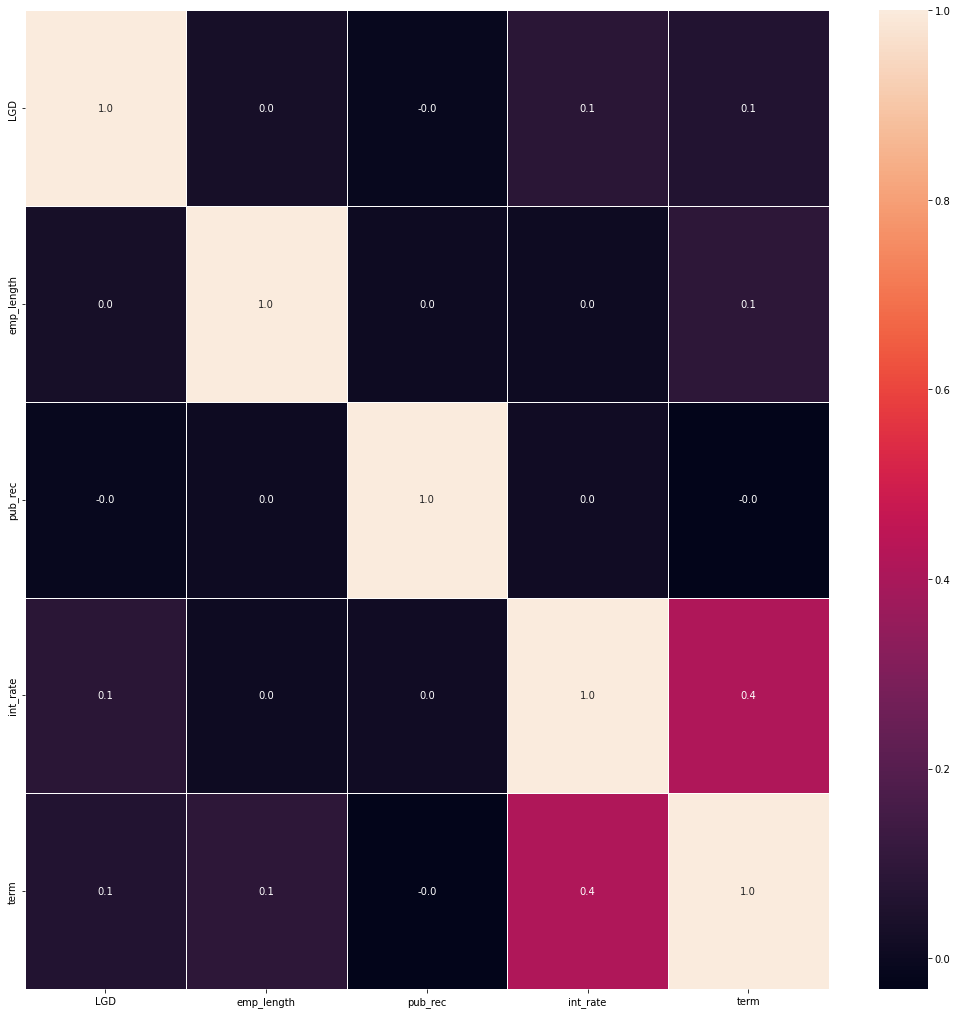

In [12]:
fig,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(train_df[NUMERICAL_FEATURES].corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

## Model Training

In [13]:
y_train = train_df[TARGET_VARIABLE]
X_train = train_df.drop(TARGET_VARIABLE, axis=1)
X_train = X_train.drop('id', axis=1)

scaler = StandardScaler()

scaler.fit(X_train)
X_train = scaler.transform(X_train)

In [14]:
dump(scaler, '../models/scalers/LGD_scaler.joblib')

['../models/scalers/LGD_scaler.joblib']

In [16]:
def objective(trial):
    params = {
        'classifier__objective': trial.suggest_categorical('classifier__objective', ['binary:logistic']),
        'regressor__n_estimators': trial.suggest_int('regressor__n_estimators', 100, 500),
        'regressor__max_depth': trial.suggest_int('regressor__max_depth', 3, 10),
        'regressor__learning_rate': trial.suggest_loguniform('regressor__learning_rate', 0.005, 0.5),
        'regressor__min_child_weight': trial.suggest_int('regressor__min_child_weight', 1, 10),
        'regressor__subsample': trial.suggest_discrete_uniform('regressor__subsample', 0.5, 0.9, 0.1),
        'regressor__colsample_bytree': trial.suggest_discrete_uniform('regressor__colsample_bytree', 0.5, 0.9, 0.1),
        'regressor__objective': trial.suggest_categorical('regressor__objective', ['reg:tweedie']),
        'regressor__tweedie_variance_power': trial.suggest_float('regressor__tweedie_variance_power', 1.01, 1.99)
    }
    
    # zir = ZeroInflatedRegressor(
    #     classifier=XGBClassifier(
    #         objective=params['classifier__objective'], 
    #         use_label_encoder=False,
    #         eval_metric="logloss"
    #     ),
    #     regressor=XGBRegressor(
    #         n_estimators=params['regressor__n_estimators'],
    #         max_depth=params['regressor__max_depth'],
    #         learning_rate=params['regressor__learning_rate'],
    #         min_child_weight=params['regressor__min_child_weight'],
    #         subsample=params['regressor__subsample'],
    #         colsample_bytree=params['regressor__colsample_bytree'],
    #         objective=params['regressor__objective']
    #     )
    # )
    regressor=XGBRegressor(
            n_estimators=params['regressor__n_estimators'],
            max_depth=params['regressor__max_depth'],
            learning_rate=params['regressor__learning_rate'],
            min_child_weight=params['regressor__min_child_weight'],
            subsample=params['regressor__subsample'],
            colsample_bytree=params['regressor__colsample_bytree'],
            objective=params['regressor__objective'],
            tweedie_variance_power=params['regressor__tweedie_variance_power'],
            random_state=42
    )
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(regressor,  X_train, y_train, cv=kfold, scoring='r2')
    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=430)

best_params = study.best_params
print(best_params)

[I 2023-05-16 03:03:24,186] A new study created in memory with name: no-name-a6f29f3d-3e81-4a3b-8ab8-4aa82adba7f5
[I 2023-05-16 03:03:43,145] Trial 0 finished with value: 0.010439020731907122 and parameters: {'classifier__objective': 'binary:logistic', 'regressor__n_estimators': 230, 'regressor__max_depth': 10, 'regressor__learning_rate': 0.016990702902069544, 'regressor__min_child_weight': 5, 'regressor__subsample': 0.8, 'regressor__colsample_bytree': 0.8, 'regressor__objective': 'reg:tweedie', 'regressor__tweedie_variance_power': 1.5843731211147878}. Best is trial 0 with value: 0.010439020731907122.
[I 2023-05-16 03:04:08,518] Trial 1 finished with value: -0.10266459940664711 and parameters: {'classifier__objective': 'binary:logistic', 'regressor__n_estimators': 357, 'regressor__max_depth': 8, 'regressor__learning_rate': 0.3964427227557487, 'regressor__min_child_weight': 4, 'regressor__subsample': 0.5, 'regressor__colsample_bytree': 0.8, 'regressor__objective': 'reg:tweedie', 'regres

After hyperparamter tuning for the zero-inflated model, it's time to finalize the model

In [15]:
model =XGBRegressor(
            n_estimators=468,
            max_depth=3,
            learning_rate=0.034475692551430764,
            min_child_weight=4,
            subsample=0.9,
            colsample_bytree=0.9,
            objective='reg:tweedie',
            tweedie_variance_power=1.9899965128531092,
            random_state=42
    )
model.fit(X_train, y_train)

dump(model, '../models/LGD_model.joblib')

['../models/LGD_model.joblib']